# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [112]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error

# magic word for producing visualizations in notebook
%matplotlib inline
%config IPCompletor.greedy = True

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
def load_data():
    
    '''
    OUTPUT - panda dataframes of the 4 customer datasets and
    2 description datasets
    '''

    # load in the data
    azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
    customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
    
    # load in descriptions of columns
    top_level_desc = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
    detailed_desc = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    
    return azdias, customers, top_level_desc, detailed_desc

azdias, customers, top_level_desc, detailed_desc = load_data()


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### I. Examine Data 

In [3]:
azdias.shape

(891221, 366)

In [4]:
azdias.isnull().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
#Find out if it is possible to use LNR variable to label customers in general population
list_customers = list(customers['LNR'])
list_azdias = list(azdias['LNR'])

In [7]:
def intersect_list(list1, list2):
    '''
    INPUT
    list1 - first list
    list2 - second list
    
    OUTPUT
    int_list - intersecting list
    '''
    int_list = list(set(list1) & set(list2))
    
    return int_list

In [8]:
list_int_indv = intersect_list(list_customers, list_azdias)
len(list_int_indv)

0

The LNR lists of the customer database do not match that of the population database. It is not possible to merge the databses based on the variable.

### II. Extract random samples with replacement from each database and test code. 

In [9]:
#Extract a random sample of data from each dataset to identify differences
azdias_subset = azdias.sample(n = 200000, replace = True)
customers_subset = customers.sample(n = 43000, replace = True )

In [10]:
#Add indicator variable to signal whether record from General Population or Customer database
azdias_subset['Cust_Ind'] = 'General'
customers_subset['Cust_Ind'] = 'Customer'

In [11]:
azdias_subset['Cust_Ind'].value_counts()

General    200000
Name: Cust_Ind, dtype: int64

In [12]:
customers_subset['Cust_Ind'].value_counts()

Customer    43000
Name: Cust_Ind, dtype: int64

In [13]:
customers_subset['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     29596
SINGLE_BUYER    13404
Name: CUSTOMER_GROUP, dtype: int64

In [14]:
customers_subset['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    22614
FOOD                 10570
COSMETIC              9816
Name: PRODUCT_GROUP, dtype: int64

In [15]:
customers_subset['ONLINE_PURCHASE'].value_counts()

0    39105
1     3895
Name: ONLINE_PURCHASE, dtype: int64

In [16]:
#Append the general population and customer subsets

def append_data(df1, df2):
    '''
    INPUT
    df1 - pandas dataframe number 1
    df2 - pandas dataframe number 2
    
    OUTPUT
    df_agg - appended pandas dataframe
    '''
    
    df_agg = pd.concat([df1, df2])
    return df_agg

df_agg = append_data(azdias_subset, customers_subset)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [17]:
df_agg['Cust_Ind'].value_counts()

General     200000
Customer     43000
Name: Cust_Ind, dtype: int64

### III. Clean dataframe for analysis

In [47]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe that will be cleaned
    
    OUTPUT
    new_df - new pandas dataframe after cleaning
    '''
    #List to keep track of columns with problems
    prob_col_list = []
    #Fill missing values of working class variable
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].fillna(0)
    for column in df:
        #Remove columns with more than 15% missing values
        if df[column].isnull().sum() > (df.shape[0]*0.15):
            df.drop(columns = [column], inplace = True)
        else:
            try:
                #fill in missing values with mean of the corresponding working class the individual is in
                df[column] = df.groupby('CAMEO_DEUG_2015')[column].transform(lambda x: x.fillna(x.mean())).round(0)            
                df[column] = df[column].astype(str).str.replace('XX', '').astype(float).round(0).astype(int)
            except:
                try:
                    df[column] = df[column].astype(str).str.replace('X', '0').astype(float).round(0).astype(int)
                except:
                        try:
                            df[column] = df[column].fillna(0).astype(str).str.replace('XX', '0').astype(float).round(0).astype(int)
                        except:
                            prob_col_list.append(column)
                
    try:
        prob_col_list.append('CAMEO_DEU_2015')
    except:
        try: 
            prob_col_list.remove('CUSTOMER_GROUP')
            prob_col_list.remove('PRODUCT_GROUP')
        except:
            pass
    
    try:
        prob_col_list.remove('Cust_Ind')
    except:
        pass

    df_new = df[df.columns.difference(prob_col_list)]
    
    return df_new, prob_col_list    

In [19]:
df_clean_agg, prob_col_list = clean_data(df_agg)

In [20]:
df_clean_cust, prob_cust_col_list = clean_data(customers_subset)

In [21]:
#Only use columns where customer dataset possess high quality data
list_agg_col = list(df_clean_agg.columns)
list_cust_col = list(df_clean_cust.columns)
list_int_col = intersect_list(list_agg_col, list_cust_col)

In [22]:
df_clean_agg = df_clean_agg[list_int_col]

In [23]:
df_clean_agg.shape

(243000, 115)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [155]:
#Create labels to distinguish General Population and Customer data points
y_cust = df_clean_agg['Cust_Ind']
X_cust = df_clean_agg.drop(columns = ['Cust_Ind'])

In [156]:
#Scale the features

def scale_features(df):
    '''
    INPUT
    df - numeric pandas dataframe that will be scaled
    
    OUTPUT
    X_stdzed - array of scaled values
    '''

    X = df.values
    X_scaled = StandardScaler().fit_transform(X)
    
    return X_scaled

In [157]:
X_cust_scaled = scale_features(X_cust)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [158]:
#Examine correlation of features
def corr_features(df):
    '''
    INPUT
    df - numeric pandas dataframe in which a correlation matrix is created
    
    OUTPUT
    A graphical correlation matrix of the features
    '''
    
    fig, ax = plt.subplots(figsize=(16,12))
    plt.title('Correlation of Features')
    sns.heatmap(df.iloc[:,:15].corr(), linewidths= 0.2, vmax=1, 
                square=True, linecolor='red', annot = True)
    plt.show();
    

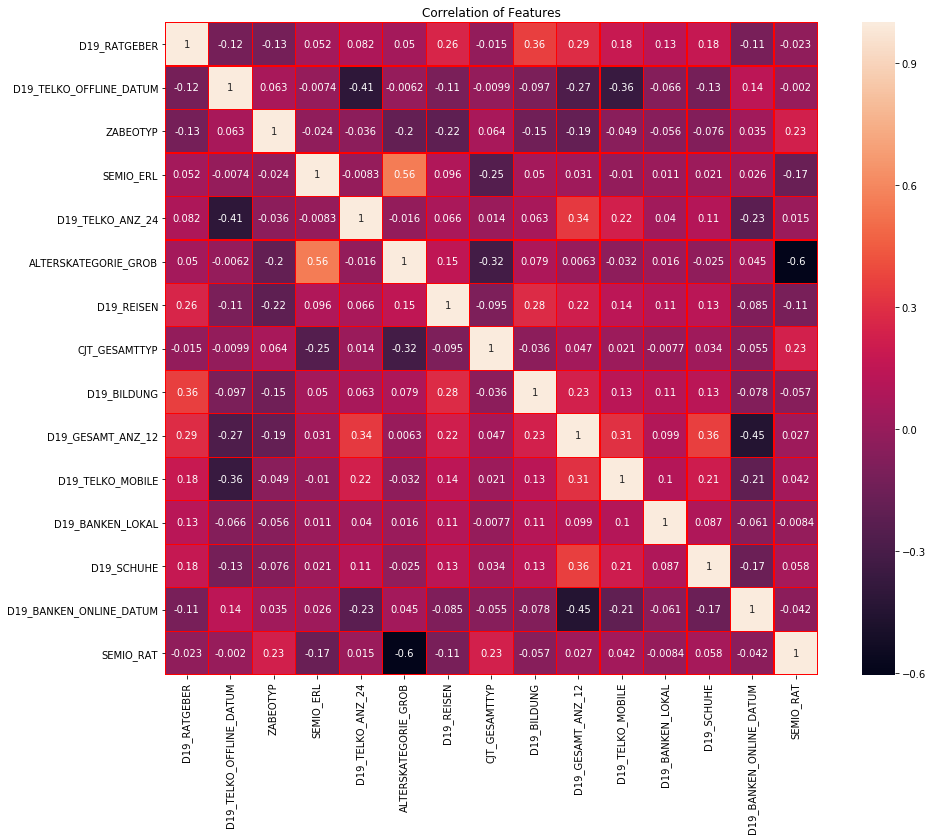

In [159]:
corr_features(X_cust)

In [160]:
def gen_eigval_eig_vec(num_array):
    '''
    INPUT
    num_array - numerical array in which eigen values and vectors are generated from
    
    OUTPUT
    eig_val - array of eigen values
    eig_vec - array of eigen vectors
    '''
    
    mean = np.mean(num_array, axis = 0)
    cov_mat = np.cov(num_array.T)
    eig_val, eig_vec = np.linalg.eig(cov_mat)
    
    return eig_val, eig_vec

eig_val, eig_vec = gen_eigval_eig_vec(X_cust_scaled)

In [161]:
def order_plot_expl_var(eig_val, eig_vec, plot = True):
    '''
    INPUT
    eig_val - array of eigen values
    eig_vec - array of eigen vectors
    plot - bool indicating whether or not a plot should be created
    
    OUTPUT
    eig_tups - tuple of ordered eigen values and vectors
    (Optional) plot of explained variance
    '''
    
    #create ordered tuples of eigen values and vectors
    eig_tups = [ (np.abs(eig_val[i]),eig_vec[:,i]) for i in range(len(eig_val))]
    eig_tups.sort(key = lambda x: x[0], reverse = True)
    
    #create %of variation explained by eah component and cumulative total
    tot_var = sum(eig_val)
    var_expl = [(i/tot_var) for i in sorted(eig_val, reverse = True)]
    cum_var = np.cumsum(var_expl)
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.title('Most important Principal components')
        plt.xlabel('Principal Components')
        plt.ylabel('Proportion of variance explained')
        plt.bar(range(len(eig_val)), var_expl, color = 'r', label = 'Principal Component')
        plt.step(range(len(eig_val)), cum_var, label = 'Cumulative variance explained')
        plt.legend(loc = 'best')
        plt.show()
        
    print('Eigen Values in descending order: \n')
    for tup in eig_tups:
        print(tup[0])
        
    return eig_tups
    

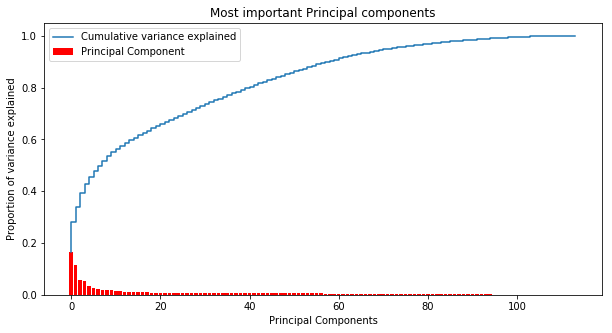

Eigen Values in descending order: 

19.030907617
13.2087535086
6.56526699745
6.17449045942
3.92805217968
3.01295911193
2.62535082965
2.32637547579
2.17117247972
1.98614191185
1.70286980183
1.49407723271
1.41338437499
1.27061403718
1.19753869412
1.11097382734
1.07098379806
1.01610673306
0.988888800272
0.978867743574
0.965391685632
0.951622461352
0.9369518426
0.924704629942
0.916555434429
0.896790318676
0.886701229085
0.876884975111
0.859223873914
0.850285086929
0.842548244085
0.825808467593
0.815546955015
0.806265439268
0.792968894856
0.788131757694
0.756509718027
0.751178167075
0.744868891159
0.735446081078
0.727686493147
0.718043491622
0.713733682265
0.709815283758
0.693498134065
0.677425636339
0.674424323447
0.669104183081
0.660630778399
0.659211370105
0.653394667475
0.643173100797
0.635701626113
0.621028131443
0.607275306606
0.598639476903
0.572584446983
0.554737971548
0.546870221192
0.527466502256
0.520561559401
0.515163902062
0.501098469415
0.457682273175
0.437116632607
0.43030105

In [162]:
eig_tups = order_plot_expl_var(eig_val, eig_vec)

In [163]:
def create_matrix_w(df, eig_tups, frac_of_feat):
    '''
    INPUT
    df - pandas dataframein which matrix ba
    eig_tups - tuples of eigen values and vectors
    
    OUTPUT
    W - projection matrix that will project the n-dimension space to a lower dimension subspace
    '''
    W = np.hstack(eig_tups[i][1].reshape(df.shape[1] -1 , 1) for i in range(int(df.shape[1]* frac_of_feat)))
    
    return W

W = create_matrix_w(df_clean_agg ,eig_tups, 0.1)

In [164]:
Y = X_cust_scaled.dot(W)

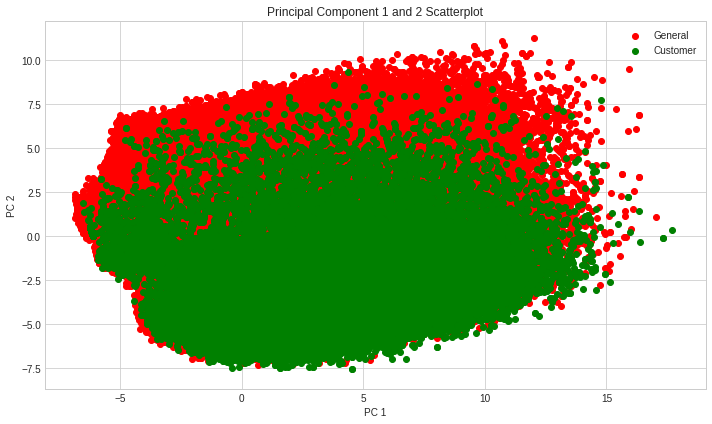

In [165]:
def create_PC_scatter(Y, y_lab):
    '''
    INPUT
    Y - Values of scaled data projected onto subspace
    y_lab - Variable to label scatterplot
    
    OUTPUT
    Scatterplot of Y with General Public and Customer labelling.
    '''

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 6))
        for lab, col in zip(('General', 'Customer'),
                            ('red', 'green')):
            plt.scatter(Y[y_lab==lab, 0],
                        Y[y_lab==lab, 1],
                        label=lab,
                        c=col)
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        plt.title('Principal Component 1 and 2 Scatterplot')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

create_PC_scatter(Y, y_cust)

Customers of the mailing company have in general lower values in PC2.

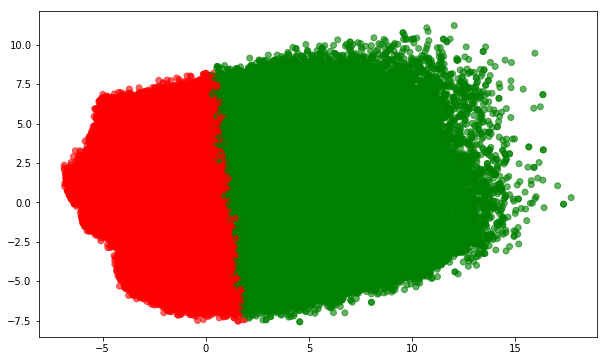

In [166]:
def setup_and_plt_kmeans(Y, n_clust):
    '''
    INPUT
    Y - Projected values of scaled features
    n_clust - the number of clusters
    
    OUTPUT
    plot of kmeans
    '''
    
    kmeans = KMeans(n_clusters= n_clust)
    
    X_clust = kmeans.fit_predict(Y)

    LABEL_COLOR_MAP = {0:'r', 1: 'g'}
    label_color = [LABEL_COLOR_MAP[i] for i in X_clust]

    # Plot the scatter digram
    plt.figure(figsize = (10,6))
    plt.scatter(Y[:,0],Y[:,1], c= label_color, alpha=0.6) 
    plt.show()
    
setup_and_plt_kmeans(Y, 2)

In this situation, there are no clear isotropic clusters k-means doesn't provide meaningful insights.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [191]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [192]:
def clean_train_df(df):
    '''
    INPUT
    df - pandas dataframe that will be cleaned
    
    OUTPUT
    clean_df - cleaned pandas dataframe
    '''
    
    clean_train_df, prob_list_train = clean_data(df)
    Y_train = clean_train_df['RESPONSE'].values
    X_train = clean_train_df.drop(columns = ['RESPONSE'])
    
    return Y_train, X_train

In [193]:
Y_train, X_train = clean_train_df(mailout_train)

In [194]:
#scale features
X_train_scaled = scale_features(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


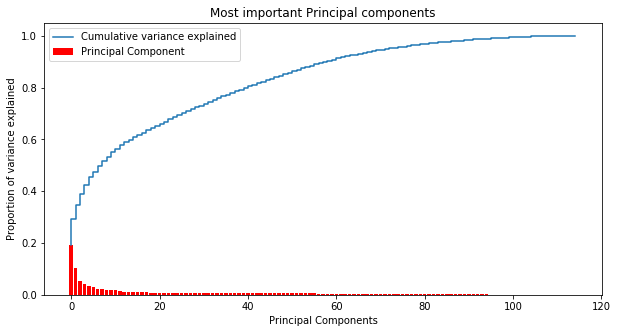

Eigen Values in descending order: 

21.9578723397
11.8662394312
6.08628315746
4.83439457561
4.08742514846
3.44069062349
2.44924458958
2.38083899189
2.22164722225
2.06407666525
1.99164019938
1.59999655062
1.41727673167
1.27119937977
1.15561998634
1.1183531388
1.0560340874
1.03595681893
1.01358794882
1.00108406295
0.995143862528
0.97333182661
0.966490163622
0.943727544641
0.930538496933
0.911773166187
0.887675284899
0.875698375574
0.860457010936
0.858641903618
0.838645270102
0.823464578827
0.812899708805
0.810753337151
0.793772434934
0.774723394757
0.767035125016
0.762953957959
0.758735170252
0.738007497459
0.728394834296
0.726177440528
0.719368797266
0.707745494227
0.694522699417
0.687643365689
0.680965017171
0.677319230689
0.664939463779
0.660241715566
0.654010558149
0.640369744744
0.628676249075
0.619542866803
0.600894965909
0.59206634958
0.569680019766
0.567954812471
0.529460668086
0.518061495275
0.506258217766
0.497621259277
0.482181577088
0.453909380536
0.411335438741
0.39898566387

In [195]:
#compute eigen values and vectors
eig_val_train, eig_vec_train = gen_eigval_eig_vec(X_train_scaled)
eig_tups_train = order_plot_expl_var(eig_val_train, eig_vec_train)

In [196]:
#Create projection matrix
W_train = create_matrix_w(mailout_train, eig_tups_train, 0.8)

In [197]:
W_train.shape

(115, 92)

In [198]:
#Project dataset to a lower dimension
X_proj_train = X_train_scaled.dot(W_train)

In [199]:
#intialize Logistic Regression and train data
lr = LogisticRegression()
lr.fit(X_proj_train, Y_train);

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [200]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [201]:
clean_test_df, prob_list_test = clean_data(mailout_test)

In [202]:
#scale features
X_test_scaled = scale_features(clean_test_df)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


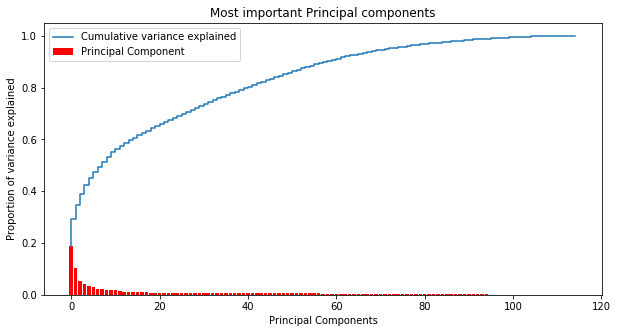

Eigen Values in descending order: 

21.8132586321
11.7870725074
6.12507374038
4.86540567696
4.06157575648
3.43926577956
2.46096304419
2.3841649409
2.22000484019
2.05228140354
2.01715590793
1.61409113982
1.41107921805
1.27650385477
1.15212579884
1.10624531193
1.06168305387
1.05233926466
1.00915907535
0.997305782588
0.994755589016
0.970202612911
0.961370247963
0.951513608311
0.930003440121
0.916128543736
0.883123466457
0.873864788575
0.868413685431
0.860732887815
0.855130965466
0.833870600558
0.824465757051
0.816292485753
0.78532925244
0.780250644626
0.768274407221
0.762908566963
0.759123958694
0.748888183281
0.736507903179
0.729274854891
0.721239787027
0.702275586349
0.698408262406
0.68313526854
0.676553290237
0.672105704893
0.665717458936
0.659018186674
0.650356951541
0.644028467584
0.641359449454
0.629290423337
0.602822665244
0.583925935892
0.58195319083
0.554287133005
0.533287058591
0.522128799819
0.520023221296
0.500212639082
0.485857122009
0.46063012566
0.413792706591
0.40628716671

In [203]:
#compute eigen values and vectors
eig_val_test, eig_vec_test = gen_eigval_eig_vec(X_test_scaled)
eig_tups_test = order_plot_expl_var(eig_val_test, eig_vec_test)

In [204]:
#Create projection matrix
W_test = create_matrix_w(mailout_train, eig_tups_test, 0.8)

In [205]:
W_test.shape

(115, 92)

In [206]:
#Project dataset to a lower dimension
X_proj_test = X_test_scaled.dot(W_test)

In [207]:
#Predict probabilities
Y_pred = lr.predict_proba(X_proj_test)

In [208]:
Y_pred_df = pd.DataFrame(Y_pred)

In [211]:
Y_pred_cust_df = Y_pred_df[1]

In [214]:
list_Y_pred_cust = list(Y_pred_cust_df)

In [215]:
mailout_test['RESPONSE_PROB'] = list_Y_pred_cust

In [217]:
mailout_test_new = mailout_test[['LNR', 'RESPONSE_PROB']]

In [220]:
mailout_test_new.to_csv('Kaggle-Bertelsmann_Competition.csv')